# S-GAN USING TENSORFLOW

In [1]:
import tensorflow as tf 
import numpy as np 
from tqdm import tqdm
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow import keras 
from tensorflow.keras import backend as k
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (
    Dense, Conv2D, UpSampling2D, Input,
    MaxPool2D, Activation,  GlobalAveragePooling2D,
    Conv2DTranspose, Dropout, Flatten
)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## DATA PREPROCESSING

1) Normalize - Normalizing the Image between -1 to 1.

2) Train_preprocessing - Here we split the data into train and validation set and then normalize the data. By default we split the data into 196 train images and 59804 validation image. This is done to check whether we are able to preform well even when less amount of data is available

In [2]:
class DataProcess:
    def __init__(self, split=0.0033, shuffle=True):
        self.split = split
        self.shuffle = shuffle
    
    def normalize(self, images, inference=False, reshape=False):
        if len(images.shape) <= 3:
            if inference:
                images = images[None, :, :, None]
            else:
                images = images[:, :, :, None]

        images = (images.astype(float) - (255/2)) / (255/2)
        return images
    
    def train_preprocess(self, data):
        images, labels = data
        if self.shuffle:
            indexes = np.arange(len(labels))
            images = images[indexes]
            labels = labels[indexes]
        images = self.normalize(images)
        train_image, val_image, train_y, val_y = train_test_split(images, labels, train_size=self.split)
        return train_image, val_image, train_y.reshape(-1, 1), val_y.reshape(-1, 1)


## GENERATOR MODEL

The Generator model is used to generate an image for just random numbers.

In [ ]:
def generator(image):
    h, w, c = image.shape
    inp_x = Input(shape=(100,))
    x = Dense(int(h/2)*int(w/2)*(c*2), activation='relu')(inp_x)
    x = Dropout(0.4)(x)
    x = k.reshape(x, (-1, int(h/2), int(w/2), int(c*2)))
    x = Conv2DTranspose(32, kernel_size=3, strides=(2,2), activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(c, kernel_size=(1,1), activation='tanh')(x)
    model = Model(inp_x, x)
    return model

## DISCRIMINATOR CUM NUMBER CLASSIFIER MODEL

The discriminator model checks wheather the image is real or is it generated by the Generator.

If the image is real then number classifier model classifies to which class the image belongs to.

In [3]:
def real_or_fake(x):
    x = k.sum(k.exp(x), axis=-1, keepdims=True)
    x = x/(x+1)
    return x

def discriminator(image):
    inp_ = Input(shape=image.shape)
    x = Conv2D(8, kernel_size=3, dilation_rate=2, activation='relu')(inp_)
    x = Dropout(0.2)(x)
    x = Conv2D(8, kernel_size=3, dilation_rate=2, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(10)(x)
    real_or_fake_ = real_or_fake(x)
    num_classification = Activation('softmax')(x)
    discriminator = Model(inp_, real_or_fake_)
    num_classification_model = Model(inp_, num_classification)
    
    return discriminator, num_classification_model

## S-GAN 

Putting it all together to form the final S-GAN model

In [5]:
def gan(generator, discriminator):
    discriminator.trainable = False
    inp = Input(shape=(100,))
    gen = generator(inp)
    dis = discriminator(gen)
    model = Model(inp, dis)
    return model

In [6]:
#Loading the Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
data_process =  DataProcess()

In [8]:
#Preproccessing the data for training the S-GAN model

train_image, val_image, train_y, val_y = data_process.train_preprocess((x_train, y_train))
x_test_ = data_process.normalize(x_test, inference=False)
y_test_ = y_test.reshape(-1, 1)
x_train_ = data_process.normalize(x_train, inference=False)
y_train_ = y_train.reshape(-1, 1)

In [9]:
generator = generator(train_image[0])

discriminator, num_classification_model = discriminator(train_image[0])

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

num_classification_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

gan_model = gan(generator, discriminator)
gan_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## TRAINING THE S-GAN MODEL

The traning of the S-GAN model is done in the same old fashion like training any other GAN. First we freeze the weights of the generator and use it to genrate an fake image. The generated images are send to the discriminator along with the real images to find the fake ones. While identifing wheather the image was a real one or a fake. After training the discriminator the real images are sent to the number classifer to identify the class the image belongs to. 

After this we freeze the discriminator and train the generator. We train the generator by telling the disciminator that the images generated by the discriminator are real 

In [10]:
def train(epochs, batch_size):
    real = np.ones((batch_size, 1))*0.9
    fake = np.ones((batch_size, 1))*0.1
    val_accuracy = []
    val_loss = []
    for epoch in range(epochs):
        num_steps = len(train_image) // batch_size
        for step in tqdm(range(num_steps)):
            if batch_size*(step+1) > len(train_image):
                x = train_image[batch_size*step : ]
                y = train_y[batch_size*step : ]
                z = np.random.normal(0, 1, (x.shape[0], 100))
            else:
                x = train_image[batch_size*step : batch_size*(step+1)]
                y = train_y[batch_size*step : batch_size*(step+1)]
                z = np.random.normal(0, 1, (batch_size, 100))

            gen_images = generator.predict(z)
            num_class_loss, accuracy = num_classification_model.train_on_batch(x, y)
            d_loss_real = discriminator.train_on_batch(x, real)
            d_loss_fake = discriminator.train_on_batch(gen_images, fake)
            
            z = np.random.normal(0, 1, (x.shape[0], 100))
            g_loss = gan_model.train_on_batch(z, real)
        result = num_classification_model.evaluate(val_image, val_y, batch_size=batch_size)
        val_accuracy.append(result[1])
        val_loss.append(result[0])
    return val_accuracy, val_loss

In [11]:
epochs = 20
batch_size = 32
val_accuracy, val_loss = train(epochs, batch_size)

100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


1869/1869 [==============================] - 8s 4ms/step - loss: 2.2579 - sparse_categorical_accuracy: 0.2038


100%|██████████| 6/6 [00:00<00:00,  9.21it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 2.2897 - sparse_categorical_accuracy: 0.2307


100%|██████████| 6/6 [00:00<00:00,  9.06it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 2.3154 - sparse_categorical_accuracy: 0.2828


100%|██████████| 6/6 [00:00<00:00,  9.19it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 2.2213 - sparse_categorical_accuracy: 0.3761


100%|██████████| 6/6 [00:00<00:00,  7.45it/s]


1869/1869 [==============================] - 8s 4ms/step - loss: 2.0411 - sparse_categorical_accuracy: 0.5660


100%|██████████| 6/6 [00:00<00:00,  9.04it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 1.9160 - sparse_categorical_accuracy: 0.5982


100%|██████████| 6/6 [00:00<00:00,  9.13it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 1.7008 - sparse_categorical_accuracy: 0.5852


100%|██████████| 6/6 [00:00<00:00,  9.24it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 1.4810 - sparse_categorical_accuracy: 0.6191


100%|██████████| 6/6 [00:00<00:00,  9.32it/s]


1869/1869 [==============================] - 8s 4ms/step - loss: 1.1817 - sparse_categorical_accuracy: 0.6419


100%|██████████| 6/6 [00:00<00:00,  9.32it/s]


1869/1869 [==============================] - 8s 4ms/step - loss: 0.9179 - sparse_categorical_accuracy: 0.7341


100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


1869/1869 [==============================] - 8s 4ms/step - loss: 0.8257 - sparse_categorical_accuracy: 0.7713


100%|██████████| 6/6 [00:00<00:00,  9.13it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 0.7411 - sparse_categorical_accuracy: 0.7871


100%|██████████| 6/6 [00:00<00:00,  9.09it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 0.7000 - sparse_categorical_accuracy: 0.7974


100%|██████████| 6/6 [00:00<00:00,  9.17it/s]


1869/1869 [==============================] - 8s 4ms/step - loss: 0.6852 - sparse_categorical_accuracy: 0.7902


100%|██████████| 6/6 [00:00<00:00,  9.01it/s]


1869/1869 [==============================] - 8s 4ms/step - loss: 0.6412 - sparse_categorical_accuracy: 0.8060


100%|██████████| 6/6 [00:00<00:00,  9.25it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 0.6111 - sparse_categorical_accuracy: 0.8151


100%|██████████| 6/6 [00:00<00:00,  8.33it/s]


1869/1869 [==============================] - 8s 4ms/step - loss: 0.6203 - sparse_categorical_accuracy: 0.8076


100%|██████████| 6/6 [00:00<00:00,  9.26it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 0.5906 - sparse_categorical_accuracy: 0.8191


100%|██████████| 6/6 [00:00<00:00,  9.26it/s]


1869/1869 [==============================] - 7s 4ms/step - loss: 0.6077 - sparse_categorical_accuracy: 0.8092


100%|██████████| 6/6 [00:00<00:00,  9.25it/s]


1869/1869 [==============================] - 8s 4ms/step - loss: 0.6120 - sparse_categorical_accuracy: 0.8144


# S-GAN RESULT

Even been low on data that is on 196 image, we were still able to achive an very high accuracy score of about 82% on the validation data and 82.1% on the test data. 

Text(0.5, 1.0, 'VALIDATION LOSS PLOT')

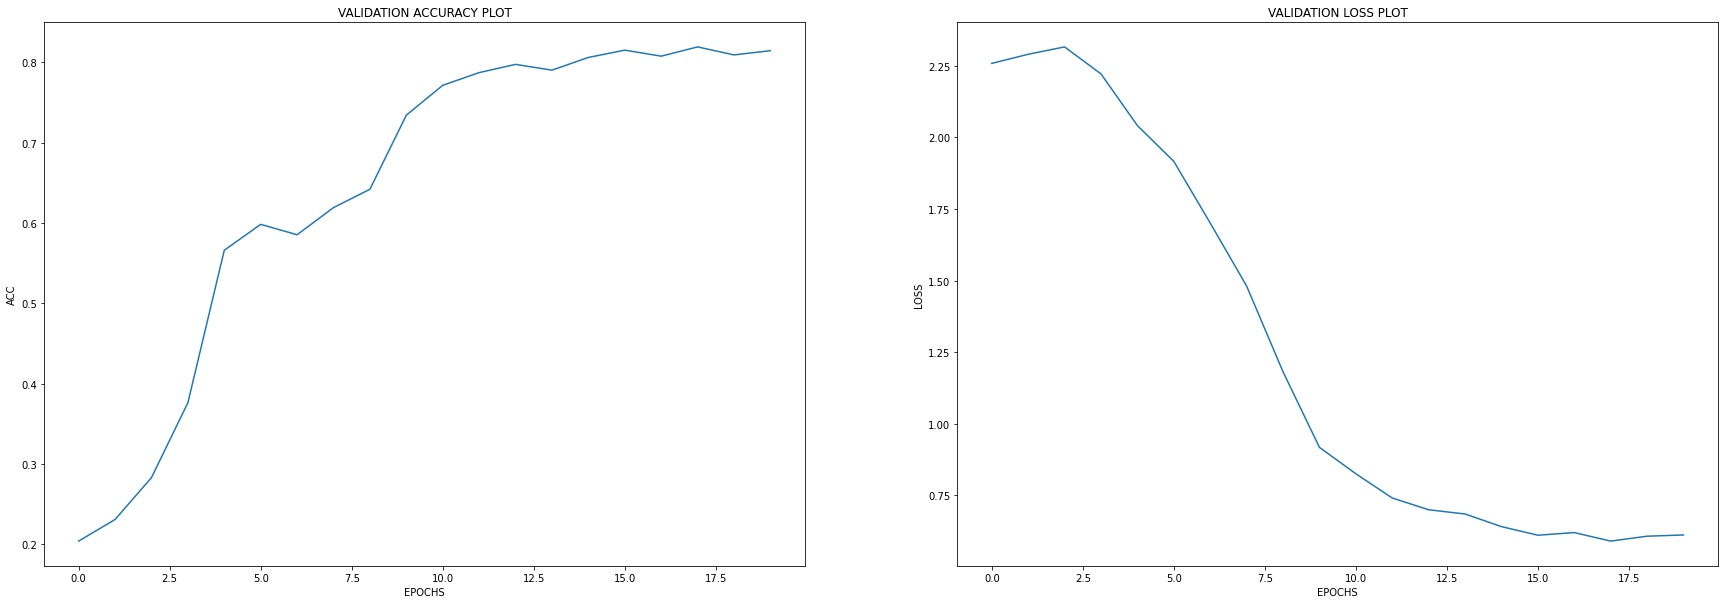

In [12]:
plt.figure(figsize=(30,10))
plt.subplot(121)
plt.plot(np.arange(epochs), val_accuracy, label='VAL ACC')
plt.xlabel('EPOCHS')
plt.ylabel('ACC')
plt.title('VALIDATION ACCURACY PLOT')
plt.subplot(122)
plt.plot(np.arange(epochs), val_loss, label='VAL LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.title('VALIDATION LOSS PLOT')

In [13]:
x_test_acc = num_classification_model.evaluate(x_test_, y_test_, batch_size=batch_size)
print(f'TEST ACCURACY = {x_test_acc[1]*100}%')

313/313 [==============================] - 1s 4ms/step - loss: 0.5795 - sparse_categorical_accuracy: 0.8219
TEST ACCURACY = 82.19000101089478%


## COMPARINING IT WITH TRAINING ON THE ENTIRE DATASET 


In [14]:
#The Same Archtecture
def simple_model(image):
    inp_ = Input(shape=image.shape)
    x = Conv2D(8, kernel_size=3, dilation_rate=2, activation='relu')(inp_)
    x = Dropout(0.2)(x)
    x = Conv2D(8, kernel_size=3, dilation_rate=2, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(10, activation='softmax')(x)
    model = Model(inp_, x)
    return model

In [15]:
epochs = 20
batch_size = 64
classifier = simple_model(train_image[0])
classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
history = classifier.fit(x_train_, y_train_, epochs=epochs, batch_size=batch_size, validation_data=(x_test_, y_test_))

Epoch 1/20
938/938 [==============================] - 20s 21ms/step - loss: 0.2824 - sparse_categorical_accuracy: 0.9152 - val_loss: 0.0893 - val_sparse_categorical_accuracy: 0.9727
Epoch 2/20
938/938 [==============================] - 21s 22ms/step - loss: 0.0990 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.0634 - val_sparse_categorical_accuracy: 0.9786
Epoch 3/20
938/938 [==============================] - 20s 22ms/step - loss: 0.0756 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.0549 - val_sparse_categorical_accuracy: 0.9818
Epoch 4/20
938/938 [==============================] - 20s 22ms/step - loss: 0.0631 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.0439 - val_sparse_categorical_accuracy: 0.9857
Epoch 5/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0561 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.0456 - val_sparse_categorical_accuracy: 0.9853
Epoch 6/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0501 - spars

## ENTIRE DATASET RESULT

We see that training the model having the same architecture as S-Gan on the entire dataset, we were able to achive an accuracy of 99.3%

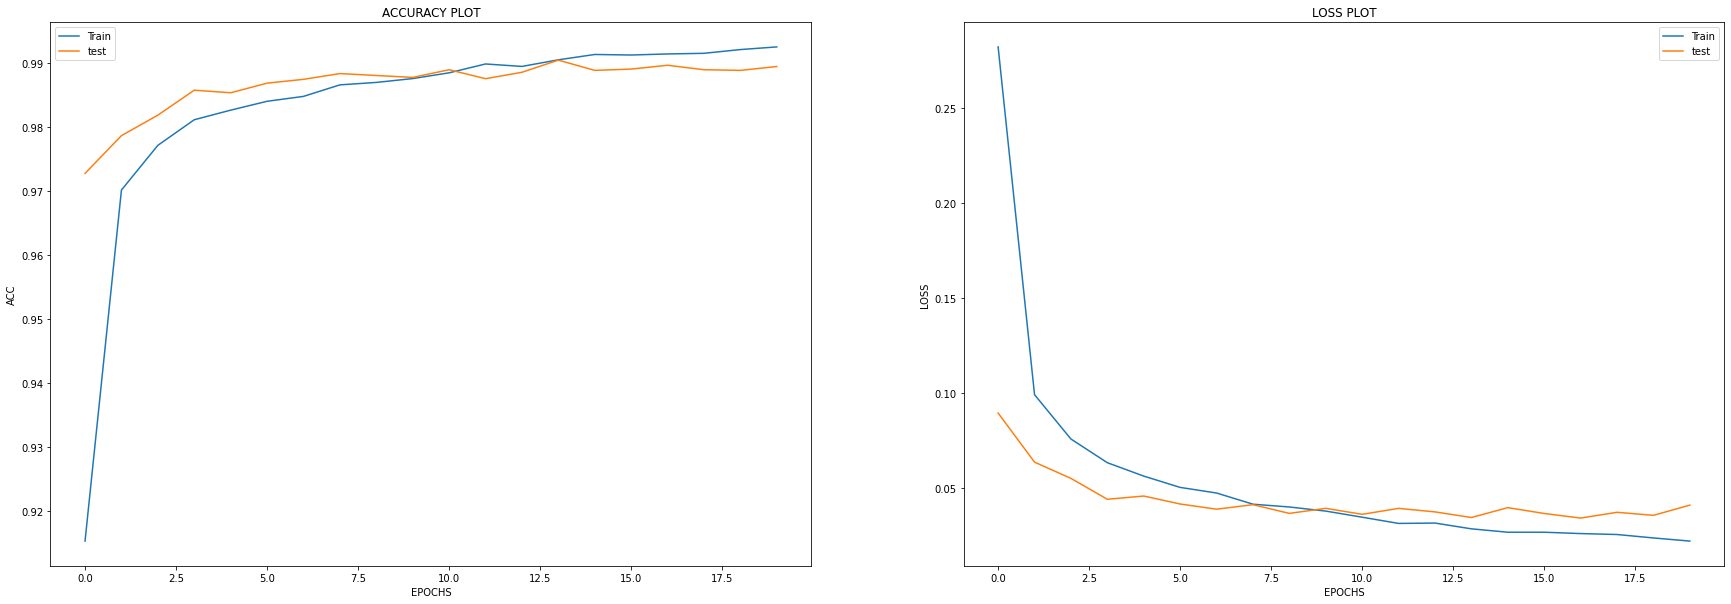

In [16]:
plt.figure(figsize=(30,10))
plt.subplot(121)
plt.plot(np.arange(epochs), history.history['sparse_categorical_accuracy'], label='Train')
plt.plot(np.arange(epochs), history.history['val_sparse_categorical_accuracy'], label='test')
plt.xlabel('EPOCHS')
plt.ylabel('ACC')
plt.title('ACCURACY PLOT')
plt.legend()
plt.subplot(122)
plt.plot(np.arange(epochs), history.history['loss'], label='Train')
plt.plot(np.arange(epochs), history.history['val_loss'], label='test')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.title('LOSS PLOT')
plt.legend()

# CONCLUSION

Using the S-GAN aproach, we obtained an high accuracy even though a very little amount of data available to us. This is very usefull in real life when we have a very little amount of data available with us. The results obtained when training the same architural network on the whole dataset were far more superior to the S-GAN, but we should not forget that the S-GAN was trained on only 0.3% of the data with an accuracy gap of oly 18%.